#### Import Libraries

In [1]:
import os 
import sys
sys.path.append('../..')
import numpy as np 
import pandas as pd
import xarray as xr 
import matplotlib.pyplot as plt 
import seaborn as sns
import cartopy.crs as ccrs
from tqdm import tqdm

import glob

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
import torchmetrics.image as t_metrics 


#Models
from models.swin_fir.swin_fir import SwinFIR_sidechannel

#Data
from dataset_utils.LightningDataModules import Era2CerraDataModule

import wandb

/home/cide/.local/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


#### Configuration

In [2]:
# Model Path
model_path = "/home/cide/Documents/5.-Downscaling/downscaling-SwinFSD/AirPollution_Run/Full_Images_200_epochs_Charbonier/output/models/example-epoch=181-val_loss=0.1960.ckpt"
data_path = "/home/cide/Documents/5.-Downscaling/downscaling-SwinFSD/data"

model_class = SwinFIR_sidechannel
constant_channels = True
num_workers = 8
crop_size_era = 35
crop_size_cerra = 140
batch_size = 1
standarized = True
transform = False

num_batches = 5

xai_channel = 0
in_channels = [0, 1, 2, 3, 4, 5]
out_channels = [0]

area = 'deterministic'
test_years = (2022, 2022)

#geo_eval = False
#deterministic_eval = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

separate_dataset = True

In [3]:
run = wandb.init(project='airpollution-downscaling-swin-fir', entity = "marcos-martinez-roig-universitat-de-val-ncia", group="era2cerra", job_type="xai", name="xai_FA_Charbonnier")

wandb: Currently logged in as: marcos-martinez-roig (marcos-martinez-roig-universitat-de-val-ncia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [4]:
model = model_class.load_from_checkpoint(model_path)
model = model.to(device)
model.eval()

/home/cide/anaconda3/envs/downscaling/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.2, which is newer than your current Lightning version: v2.5.1.post0


Dataset metrics provided. Using provided values.
Dataset metrics provided. Using provided values.


SwinFIR_sidechannel(
  (loss_function): CharbonnierLoss()
  (conv_first): Conv2d(6, 220, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (sidechannel_conv_first): Conv2d(2, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((220,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (downsample_sidechannel): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(20, 20, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (sidechannel_patch_embed): PatchEmbed(
    (norm): LayerNorm((20,), eps=1e-05, elementwise_affine=True)
  )
  (sidechannel_patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=240, input_resolution=(35, 35), depth=5
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=240, input_resolution=(35, 35)

In [5]:
channel_names = np.array(model.hparams.channel_names)
out_channel_names = channel_names[out_channels]
in_channel_names = channel_names[in_channels]
in_channel_names[-1] = 't2m' #Error during training
names_side = ['pop', 'z']
all_channel_names = list(in_channel_names) + names_side
channel_names = channel_names.squeeze()
print(f"Out channels: {out_channel_names}, In channels: {in_channel_names}")

Out channels: ['pm2p5'], In channels: ['pm2p5' 'blh' 'u10' 'v10' 'd2m' 't2m']


In [6]:
wandb.config['data_path'] = data_path
wandb.config['model_path'] = model_path
wandb.config['model'] = model_class.__name__
wandb.config['constant_channels'] = constant_channels
wandb.config['crop_size_era'] = crop_size_era
wandb.config['crop_size_cerra'] = crop_size_cerra
wandb.config['batch_size'] = batch_size
wandb.config['test_years'] = test_years
wandb.config['channel_names'] = channel_names.tolist()
wandb.config['in_channels'] = in_channels
wandb.config['xai_channel'] = xai_channel #out_channel_names[xai_channel]

#### Load Data

In [7]:
data_module = Era2CerraDataModule(data_path, batch_size=batch_size, standarized=standarized, transform=transform,
                                  crop_size_era=crop_size_era, crop_size_cerra=crop_size_cerra, cropping=area, 
                                  spatial_split_test=test_years, 
                                  return_era_original=False, 
                                  return_offset=True, 
                                  downscaling_factor=1, #model.hparams.upscale, 
                                  constant_channels=constant_channels, 
                                  num_workers=num_workers, 
                                  out_channels=model.hparams.out_channels, 
                                  in_channels=in_channels, 
                                  use_separate_dataset=separate_dataset)


data_module.setup('test')

dataloader = data_module.test_dataloader()

Loading Era2Cerra DataModule 

Loaded Mean/Std from file
Loaded Mean/Std from file
Using ERA5 and CERRA dataset with separate u10/v10
Returning the following channels as LR-input: [0, 1, 2, 3, 4, 5]
Number of Files 1
Loaded Mean/Std from file
Loaded Mean/Std from file
torch.Size([2, 420, 700])
Loaded constant data from file


#### Metrics functions

In [8]:
def get_metrics(preds, targets, sl_mask, frame):
    
    metric_dict = {}

    metrics = ['l1Error', 'l2Error', 'Bias_time', 'Bias_space', 'Corr_time', 'Corr_space', 'RMSE_time', 'RMSE_space', 'PeakSignalNoiseRatio']#, 'StructuralSimilarityIndexMeasure', 'UniversalImageQualityIndex']

    metric_settings = {
        'l1Error': {},
        'l2Error': {},
        'Bias_time': {},
        'Bias_space': {},
        'Corr_time': {},
        'Corr_space': {},
        'RMSE_time': {},
        'RMSE_space': {},
        'PeakSignalNoiseRatio': {'torchmetric_settings': {'data_range': 366.35}},# max = 366.35 / p99 = 27.72 / p90 = 11.94
        'StructuralSimilarityIndexMeasure': {'torchmetric_settings': {}},
        'UniversalImageQualityIndex': {'torchmetric_settings': {}},
        'FrechetInceptionDistance': {'torchmetric_settings': {}},
        'KernelInceptionDistance': {'torchmetric_settings': {}}
    }

    for metric in metrics:

        print('Calculating {}...'.format(metric))

        settings = metric_settings[metric]

        sl_mask_bool = False

        if 'l1Error' in metric:
            
            l1_loss_t, l1_loss_sl = compute_loss(preds, targets, nn.L1Loss(reduction='mean'), sl_mask, sl_mask_bool)

            metric_dict[f'{frame}/l1Error_total'] = l1_loss_t
            if sl_mask_bool:
                metric_dict[f'{frame}/l1Error_sl'] = l1_loss_sl

        elif 'l2Error' in metric:
            
            l2_loss_t, l2_loss_sl = compute_loss(preds, targets, nn.MSELoss(reduction='mean'), sl_mask, sl_mask_bool)
            metric_dict[f'{frame}/l2Error_total'] = l2_loss_t
            if sl_mask_bool:
                metric_dict[f'{frame}/l2Error_sl'] = l2_loss_sl

        elif 'Bias_time' in metric:
            
            bias_map_time, bias_map_time_sl, bias_time, bias_time_sl = compute_bias_time(preds, targets, sl_mask, sl_mask_bool)
            metric_dict[f'{frame}/Bias_map_time'] = bias_map_time
            metric_dict[f'{frame}/Bias_time'] = bias_time
            if sl_mask_bool:
                metric_dict[f'{frame}/Bias_map_time_sl'] = bias_map_time_sl
                metric_dict[f'{frame}/Bias_time_sl'] = bias_time_sl

        elif 'Bias_space' in metric:
            
            bias_map_space, bias_map_space_sl, bias_space, bias_space_sl = compute_bias_space(preds, targets, sl_mask, sl_mask_bool)

            metric_dict[f'{frame}/Bias_map_space'] = bias_map_space
            metric_dict[f'{frame}/Bias_space'] = bias_space
            if sl_mask_bool:
                metric_dict[f'{frame}/Bias_map_space_sl'] = bias_map_space_sl
                metric_dict[f'{frame}/Bias_space_sl'] = bias_space_sl

        elif 'Corr_time' in metric:
            
            correlation_map_time, correlation_map_time_sl, correlation_time, correlation_time_sl = compute_corr_time(preds, targets, sl_mask, sl_mask_bool)

            metric_dict[f'{frame}/Corr_map_time'] = correlation_map_time
            metric_dict[f'{frame}/Corr_time'] = correlation_time
            if sl_mask_bool:
                metric_dict[f'{frame}/Corr_map_time_sl'] = correlation_map_time_sl
                metric_dict[f'{frame}/Corr_time_sl'] = correlation_time_sl

        elif 'Corr_space' in metric:
            
            correlation_map_space, correlation_map_space_sl, correlation_space, correlation_space_sl = compute_corr_space(preds, targets, sl_mask, sl_mask_bool)

            metric_dict[f'{frame}/Corr_map_space'] = correlation_map_space
            metric_dict[f'{frame}/Corr_space'] = correlation_space
            if sl_mask_bool:
                metric_dict[f'{frame}/Corr_map_space_sl'] = correlation_map_space_sl
                metric_dict[f'{frame}/Corr_space_sl'] = correlation_space_sl


        elif 'RMSE_time' in metric:
            
            rmse_map_time, rmse_map_time_sl, rmse_time, rmse_time_sl = compute_rmse_time(preds, targets, sl_mask, sl_mask_bool)

            metric_dict[f'{frame}/RMSE_map_time'] = rmse_map_time
            metric_dict[f'{frame}/RMSE_time'] = rmse_time
            if sl_mask_bool:
                metric_dict[f'{frame}/RMSE_map_time_sl'] = rmse_map_time_sl
                metric_dict[f'{frame}/RMSE_time_sl'] = rmse_time_sl

        elif 'RMSE_space' in metric:
            
            rmse_map_space, rmse_map_space_sl, rmse_space, rmse_space_sl = compute_rmse_space(preds, targets, sl_mask, sl_mask_bool)

            metric_dict[f'{frame}/RMSE_map_space'] = rmse_map_space
            metric_dict[f'{frame}/RMSE_space'] = rmse_space
            if sl_mask_bool:
                metric_dict[f'{frame}/RMSE_map_space_sl'] = rmse_map_space_sl
                metric_dict[f'{frame}/RMSE_space_sl'] = rmse_space_sl


        else:
            metric_outputs = calculate_metric(metric, preds, targets, torchmetrics_settings=settings['torchmetric_settings'])
            metric_dict[f'{frame}/{metric}'] = metric_outputs

            #if len(metric_outputs) > 1:
            #    for k, metric_name in enumerate(settings['outputs']):
            #        metric_dict[f'{frame}/{metric}_{metric_name}'] = metric_outputs[k]
            #else:
            #    metric_dict[f'{frame}/{metric}'] = metric_outputs[0]

    return metric_dict

def compute_loss(pred, target, loss_fn, sl_mask, land_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    loss_total = loss_fn(pred, target).item()

    if land_bool:
        # Create a mask to ignore NaN values
        mask = ~torch.isnan(sl_mask.unsqueeze(0).expand_as(pred))

        # Apply masks to vectors
        pred_land = pred[mask]
        target_land = target[mask]

        loss_land = loss_fn(pred_land, target_land).item()
    else:
        loss_land = 0

    return loss_total, loss_land

def compute_bias_time(pred, target, sl_mask, land_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    bias_map_time = torch.mean(pred - target, dim=0)

    # Máscara para España
    if land_bool:
        bias_map_time_land = torch.where(sl_mask.isnan(), float('nan'), bias_map_time)
    else:
        bias_map_time_land = torch.zeros_like(bias_map_time)

    return (bias_map_time, bias_map_time_land, torch.nanmean(bias_map_time).item(), torch.nanmean(bias_map_time_land).item())

def compute_bias_space(pred, target, sl_mask, land_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # First, the spatial dimension (lat and lon) are planned. Dimensions now is time, lat * lon
    pred_flattened = pred.view(pred.shape[0], -1)
    target_flattened = target.view(pred.shape[0], -1)

    # Calculation of the bias
    bias_map_space = torch.mean(pred_flattened - target_flattened, dim=1)

    # sl_mask
    if land_bool:
        mask = ~torch.isnan(sl_mask.flatten())
        pred_land = pred_flattened[:, mask]
        target_land = target_flattened[:, mask]  

        bias_map_space_land = torch.mean(pred_land - target_land, dim=1)
    else:
        bias_map_space_land = torch.zeros_like(bias_map_space)
                
    return bias_map_space, bias_map_space_land, torch.nanmean(bias_map_space).item(), torch.nanmean(bias_map_space_land).item()
  
def compute_corr_time(pred, target, sl_mask, land_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # Calculation of the Correlation: 
    # r = Cov(X, Y)/(sigma_x * sigma_y)
    
    # Calcule the means
    pred_mean  = torch.mean(pred, dim=0)
    target_mean = torch.mean(target, dim=0)

    # Calcule the Covariance and standard deviations
    covariance = torch.mean(pred * target, dim=0) - pred_mean * target_mean
    pred_var = torch.mean(pred ** 2, dim=0) - pred_mean ** 2
    target_var = torch.mean(target ** 2, dim=0) - target_mean ** 2

    # Correlation
    corr_map_time = covariance / (torch.sqrt(pred_var) * torch.sqrt(target_var))

    # Check for pixels with standard variance approximately 0, i.e., correlation values >1 or <-1
    corr_map_time[corr_map_time>1] = float('nan')
    corr_map_time[corr_map_time<-1] = float('nan')

    # sl_mask
    if land_bool:
        corr_map_time_land = torch.where(sl_mask.isnan(), float('nan'), corr_map_time)
    else:
        corr_map_time_land = torch.zeros_like(corr_map_time)

    return corr_map_time, corr_map_time_land, torch.nanmean(corr_map_time).item(), torch.nanmean(corr_map_time_land).item()

def compute_corr_space(pred, target, sl_mask, land_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # First, the spatial dimension (lat and lon) are planned. Dimensions now is time, lat * lon
    pred_flattened = pred.view(pred.shape[0], -1)
    target_flattened = target.view(pred.shape[0], -1)

    # Calculation of the Means
    pred_mean = torch.mean(pred_flattened, dim=1)
    target_mean = torch.mean(target_flattened, dim=1)

    # Calculation of covariance and standard deviations
    covariance = torch.mean(pred_flattened * target_flattened, dim=1) - pred_mean * target_mean
    pred_var = torch.mean(pred_flattened ** 2, dim=1) - pred_mean ** 2
    target_var = torch.mean(target_flattened ** 2, dim=1) - target_mean ** 2

    # Correlation
    corr_map_space = covariance / (torch.sqrt(pred_var) * torch.sqrt(target_var))
    corr_map_space[torch.isnan(corr_map_space)] = 0

    # sl_mask
    if land_bool:
        mask = ~torch.isnan(sl_mask.flatten())
        pred_land = pred_flattened[:, mask]
        target_land = target_flattened[:, mask]

        # Calculation of the Means
        pred_mean_land = torch.mean(pred_land, dim=1)
        target_mean_land = torch.mean(target_land, dim=1)

        # Calculation of covariance and standard deviations
        covariance_land = torch.mean(pred_land * target_land, dim=1) - pred_mean_land * target_mean_land
        pred_var_land = torch.mean(pred_land ** 2, dim=1) - pred_mean_land ** 2
        target_var_land = torch.mean(target_land ** 2, dim=1) - target_mean_land ** 2

        # Correlation
        corr_map_space_land = covariance_land / (torch.sqrt(pred_var_land) * torch.sqrt(target_var_land))
        corr_map_space_land[torch.isnan(corr_map_space_land)] = 0    
    else:
        corr_map_space_land = torch.zeros_like(corr_map_space)
                
    return corr_map_space, corr_map_space_land, torch.nanmean(corr_map_space).item(), torch.nanmean(corr_map_space_land).item()

def compute_rmse_time(pred, target, sl_mask, land_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # Calculation of the Full RMSE
    rmse_map_time = torch.sqrt(torch.mean((pred - target) ** 2, dim=0))

    # sl_mask
    if land_bool:
        rmse_map_time_land = torch.where(sl_mask.isnan(), float('nan'), rmse_map_time)
    else:
        rmse_map_time_land = torch.zeros_like(rmse_map_time)

    return rmse_map_time, rmse_map_time_land, torch.nanmean(rmse_map_time).item(), torch.nanmean(rmse_map_time_land).item() 

def compute_rmse_space(pred, target, sl_mask, land_bool):

    assert pred.shape == target.shape, "The prediction and target dimensions are different"

    # First, the spatial dimension (lat and lon) are planned. Dimensions now is time, lat * lon
    pred_flattened = pred.view(pred.shape[0], -1)
    target_flattened = target.view(pred.shape[0], -1)

    # Calculation of the RMSE
    rmse_map_space = torch.sqrt(torch.mean((pred_flattened - target_flattened) ** 2, dim=1))

    # sl_mask
    if land_bool:
        mask = ~torch.isnan(sl_mask.flatten())
        pred_land = pred_flattened[:, mask]
        target_land = target_flattened[:, mask]

        rmse_map_space_land = torch.sqrt(torch.mean((pred_land - target_land) ** 2, dim=1))
    else:
        rmse_map_space_land = torch.zeros_like(rmse_map_space)
                
    return rmse_map_space, rmse_map_space_land, torch.nanmean(rmse_map_space).item(), torch.nanmean(rmse_map_space_land).item()

def calculate_metric(name_expr, pred, target, torchmetrics_settings={}, part=5000):

    metric_str = [m for m in t_metrics.__dict__.keys() if (name_expr == m)]

    if len(metric_str) == 0:
        metric_str = [m for m in t_metrics.__dict__.keys() if (name_expr in m)]
        if len(metric_str) > 1:
            warnings.warn('found multiple hits for metric name {}. Will use {}'.format(name_expr, metric_str[0]))

    assert len(metric_str) > 0, 'metric {} not found in torchmetrics.image. Maybe torch-fidelity is missing.'.format(name_expr)

    metric = t_metrics.__dict__[metric_str[0]](**torchmetrics_settings)

    total_sum = 0.0
    total_batches = 0

    for i in range(0, pred.size(0), part):

        batch_preds = pred[i:min(i + part, pred.size(0))]
        batch_targets = target[i:min(i + part, pred.size(0))]
    
        with torch.no_grad():
            value = metric(batch_preds, batch_targets).item()
            total_sum += value
            total_batches += 1
    
    del batch_preds, batch_targets

    return total_sum/total_batches

#### Load the spanish map

In [9]:
mask_bool = False

if mask_bool:
    # Define the path
    data_path = os.path.join(os.getcwd(), '..', '..', 'input_data', 'hourly')

    # Read the data
    sl_mask = xr.open_dataset(os.path.join(data_path, 'mask_sl.nc'))["mask_sl"].values
    sl_mask = torch.tensor(sl_mask).to('cpu')
else:
    sl_mask = 0

#### Run Test

In [10]:
def test(model, dataloader, frame=None, xAI_technique=None, noise_type=None, sigma=None):

    # Define empty lists to keep the predictions
    target_main_coll = torch.zeros((len(dataloader.dataset), len(out_channels), model.hparams.full_height_cerra, model.hparams.full_width_cerra), device='cpu')
    target_side_coll = torch.zeros((len(dataloader.dataset), 2, model.hparams.full_height_cerra, model.hparams.full_width_cerra), device='cpu')
    pred_main_coll = torch.zeros((len(dataloader.dataset), len(out_channels), model.hparams.full_height_cerra, model.hparams.full_width_cerra), device='cpu')
    pred_side_coll = torch.zeros((len(dataloader.dataset), 2, model.hparams.full_height_cerra, model.hparams.full_width_cerra), device='cpu')

    model.eval()
    with torch.no_grad():
    
        t = tqdm(dataloader, leave=True, total=len(dataloader))
        
        for i, (inputVar, targetVar, pos, _) in enumerate(t):

            x, x_side = inputVar
            y, y_side = targetVar

            indices = pos[-1]

            #t.set_description("Epoch = {}".format(i))
            
            x = x.to(device)
            x_side = x_side.to(device)
            y = y#.to(device)
            y_side = y_side#.to(device)

            if xAI_technique == 'feature_ablation':
                if frame<6:
                    x[:, frame, :, :] = 0
                else:
                    x_side[:, frame - 6, :, :] = 0

            elif xAI_technique == 'random_perturbation':

                if noise_type == 'gaussian_zero':

                    if frame<6:
                        input_shape = (x.shape[0], x.shape[2], x.shape[3])
                        noise = sigma * torch.randn(input_shape, device=device)
                        x[:, frame, :, :] = noise
                    else:
                        input_shape = (y.shape[0], y.shape[2], y.shape[3])
                        noise = sigma * torch.randn(input_shape, device=device)
                        x_side[:, frame - 6, :, :] = noise
                                        
                    del noise
                
                # Typical noise due to error in measurements
                if noise_type == 'gaussian':

                    if frame<6:
                        input_shape = (x.shape[0], x.shape[2], x.shape[3])
                        noise = sigma * torch.randn(input_shape, device=device)
                        x[:, frame, :, :] += noise
                    else:
                        input_shape = (y.shape[0], y.shape[2], y.shape[3])
                        noise = sigma * torch.randn(input_shape, device=device)
                        x_side[:, frame - 6, :, :] += noise
                                        
                    del noise

                # More realistic. Proportional to the size of the value
                elif noise_type =='speckle':

                    if frame<6:
                        input_shape = (x.shape[0], x.shape[2], x.shape[3])
                        noise = sigma * torch.randn(input_shape, device=device)
                        x[:, frame, :, :] *= (1 + noise) 
                    else:
                        input_shape = (y.shape[0], y.shape[2], y.shape[3])
                        noise = sigma * torch.randn(input_shape, device=device)
                        x_side[:, frame - 6, :, :] *= (1 + noise) 
                    
                    del noise

                # Error used for bias in measurements
                elif noise_type == 'uniform':

                    if frame<6:
                        input_shape = (x.shape[0], x.shape[2], x.shape[3])
                        noise = sigma * (2 * torch.rand(input_shape, device=device) - 1) 
                        x[:, frame, :, :] += noise
                    else:
                        input_shape = (y.shape[0], y.shape[2], y.shape[3])
                        noise = sigma * (2 * torch.rand(input_shape, device=device) - 1) 
                        x_side[:, frame - 6, :, :] += noise
                    
                    del noise

                #### Less interesting for wind speed at 10 meters
                elif noise_type =='salt_pepper':

                    if frame<6:
                        input_shape = (x.shape[0], x.shape[2], x.shape[3])

                        # sigma is the porbability of corruption
                        prob = sigma  
                        salt = torch.rand(input_shape, device=device) < (prob / 2)
                        pepper = torch.rand(input_shape, device=device) < (prob / 2)

                        x[:, frame, :, :][salt] = 1  # "Salt"
                        x[:, frame, :, :][pepper] = 0  # "Pepper"
                    else:
                        input_shape = (y.shape[0], y.shape[2], y.shape[3])

                        # sigma is the porbability of corruption
                        prob = sigma  
                        salt = torch.rand(input_shape, device=device) < (prob / 2)
                        pepper = torch.rand(input_shape, device=device) < (prob / 2)

                        x_side[:, frame - 6, :, :][salt] = 1  # "Salt"
                        x_side[:, frame - 6, :, :][pepper] = 0  # "Pepper"

                    del salt, pepper

                elif noise_type == 'poisson':

                    if frame<6:
                        lam = torch.abs(x[:, frame, :, :] * sigma)  
                        noise = torch.poisson(lam)
                        x[:, frame, :, :] += noise
                    else:
                        lam = torch.abs(x_side[:, frame - 6, :, :] * sigma)  
                        noise = torch.poisson(lam)
                        x_side[:, frame - 6, :, :] += noise 

                    del lam, noise

                else:
                    raise ValueError('Noise type not recognized')
            
            else:
                pass
                          
            y_hat, y_hat_side = model((x, x_side))

            #y_hat = torch.zeros_like(y)
            #y_hat_side = torch.zeros_like(y_side)

            y_hat = y_hat.squeeze(0)
            y_hat_side = y_hat_side.squeeze(0)

            # save data according to the correct index
            for j, index in enumerate(indices):
                   
                #saving variables
                #input_coll[index] = inputs[j].detach().cpu()
                target_main_coll[index] = y[j].detach()#.cpu()
                target_side_coll[index] = y_side[j].detach().cpu()
                pred_main_coll[index] = y_hat[j].detach()#.cpu()
                pred_side_coll[index] = y_hat_side[j].detach().cpu()
            
            del x, x_side, y, y_side, y_hat, y_hat_side, indices
            
    return target_main_coll, target_side_coll, pred_main_coll, pred_side_coll

#### Parameters

In [11]:
xAI_technique = 'feature_ablation' #feature_ablation or random_perturbation
frame = 0
sigma = 0.1
noise_type = 'gaussian' #gaussian, speckle, uniform, salt_pepper, poisson

In [12]:
torch.cuda.empty_cache()

In [13]:
all_metrics = {}

print('Run normal one...')

# Obtain normal predictions
target_main, target_side, pred_main, pred_side = test(model, dataloader)

# Calcule metrics
metrics = get_metrics(pred_main, target_main, sl_mask, 'base')

all_metrics.update(metrics)

torch.cuda.empty_cache()

del pred_main, pred_side, metrics

print()
print('Run with modified data using ', xAI_technique)
for var in range(0, 8, 1):
    print()
    print('Variable: ', var)

    # Obtain occluded predictions
    _, _, pred_main, pred_side = test(model, dataloader, var, xAI_technique, noise_type, sigma)

    # Calcule metrics
    metrics = get_metrics(pred_main, target_main, sl_mask, all_channel_names[var])

    all_metrics.update(metrics)

    torch.cuda.empty_cache()

    del pred_main, pred_side, metrics

Run normal one...


100%|██████████| 131/131 [05:22<00:00,  2.46s/it]


Calculating l1Error...
Calculating l2Error...
Calculating Bias_time...
Calculating Bias_space...
Calculating Corr_time...
Calculating Corr_space...
Calculating RMSE_time...
Calculating RMSE_space...
Calculating PeakSignalNoiseRatio...

Run with modified data using  feature_ablation

frame:  0


100%|██████████| 131/131 [05:03<00:00,  2.31s/it]


Calculating l1Error...
Calculating l2Error...
Calculating Bias_time...
Calculating Bias_space...
Calculating Corr_time...
Calculating Corr_space...
Calculating RMSE_time...
Calculating RMSE_space...
Calculating PeakSignalNoiseRatio...

frame:  1


100%|██████████| 131/131 [04:52<00:00,  2.23s/it]


Calculating l1Error...
Calculating l2Error...
Calculating Bias_time...
Calculating Bias_space...
Calculating Corr_time...
Calculating Corr_space...
Calculating RMSE_time...
Calculating RMSE_space...
Calculating PeakSignalNoiseRatio...

frame:  2


100%|██████████| 131/131 [05:03<00:00,  2.32s/it]


Calculating l1Error...
Calculating l2Error...
Calculating Bias_time...
Calculating Bias_space...
Calculating Corr_time...
Calculating Corr_space...
Calculating RMSE_time...
Calculating RMSE_space...
Calculating PeakSignalNoiseRatio...

frame:  3


100%|██████████| 131/131 [04:49<00:00,  2.21s/it]


Calculating l1Error...
Calculating l2Error...
Calculating Bias_time...
Calculating Bias_space...
Calculating Corr_time...
Calculating Corr_space...
Calculating RMSE_time...
Calculating RMSE_space...
Calculating PeakSignalNoiseRatio...

frame:  4


100%|██████████| 131/131 [06:09<00:00,  2.82s/it]


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


Calculating l1Error...
Calculating l2Error...
Calculating Bias_time...
Calculating Bias_space...
Calculating Corr_time...
Calculating Corr_space...
Calculating RMSE_time...
Calculating RMSE_space...
Calculating PeakSignalNoiseRatio...

frame:  5


100%|██████████| 131/131 [05:19<00:00,  2.44s/it]


Calculating l1Error...
Calculating l2Error...
Calculating Bias_time...
Calculating Bias_space...
Calculating Corr_time...
Calculating Corr_space...
Calculating RMSE_time...
Calculating RMSE_space...
Calculating PeakSignalNoiseRatio...

frame:  6


100%|██████████| 131/131 [05:54<00:00,  2.70s/it]


Calculating l1Error...
Calculating l2Error...
Calculating Bias_time...
Calculating Bias_space...
Calculating Corr_time...
Calculating Corr_space...
Calculating RMSE_time...
Calculating RMSE_space...
Calculating PeakSignalNoiseRatio...

frame:  7


100%|██████████| 131/131 [05:22<00:00,  2.47s/it]


Calculating l1Error...
Calculating l2Error...
Calculating Bias_time...
Calculating Bias_space...
Calculating Corr_time...
Calculating Corr_space...
Calculating RMSE_time...
Calculating RMSE_space...
Calculating PeakSignalNoiseRatio...


#### Metric dict example

In [15]:
test_metrics = False

if test_metrics:

    print('Using random metrics')

    import random

    # Lista de variables (puedes adaptar o cargar desde otro lado)
    variables = ['base', 'pm2p5', 'blh', 'u10', 'v10', 'd2m', 't2m', 'pop', 'z']

    # Lista de métricas
    metrics = [
        'l1Error_total', 'l2Error_total',
        'Bias_map_time', 'Bias_time',
        'Bias_map_space', 'Bias_space',
        'Corr_map_time', 'Corr_time',
        'Corr_map_space', 'Corr_space',
        'RMSE_map_time', 'RMSE_time',
        'RMSE_map_space', 'RMSE_space',
        'PeakSignalNoiseRatio'
    ]

    # Semilla opcional para reproducibilidad
    torch.manual_seed(42)
    random.seed(42)

    # Crear el diccionario
    all_metrics = {}

    for var in variables:
        for metric in metrics:
            key = f"{var}/{metric}"

            if "map" in metric:
                if "space" in metric:
                    all_metrics[key] = torch.rand((1, 131))
                elif "time" in metric:
                    all_metrics[key] = torch.rand((1, 420, 700))            
                else:
                    raise ValueError(f"Métrica con 'map' inesperada: {metric}")

            else:
                # Tensor escalar
                all_metrics[key] = np.abs(random.uniform(-1, 1))

In [16]:
all_metrics.keys()

dict_keys(['base/l1Error_total', 'base/l2Error_total', 'base/Bias_map_time', 'base/Bias_time', 'base/Bias_map_space', 'base/Bias_space', 'base/Corr_map_time', 'base/Corr_time', 'base/Corr_map_space', 'base/Corr_space', 'base/RMSE_map_time', 'base/RMSE_time', 'base/RMSE_map_space', 'base/RMSE_space', 'base/PeakSignalNoiseRatio', 'pm2p5/l1Error_total', 'pm2p5/l2Error_total', 'pm2p5/Bias_map_time', 'pm2p5/Bias_time', 'pm2p5/Bias_map_space', 'pm2p5/Bias_space', 'pm2p5/Corr_map_time', 'pm2p5/Corr_time', 'pm2p5/Corr_map_space', 'pm2p5/Corr_space', 'pm2p5/RMSE_map_time', 'pm2p5/RMSE_time', 'pm2p5/RMSE_map_space', 'pm2p5/RMSE_space', 'pm2p5/PeakSignalNoiseRatio', 'blh/l1Error_total', 'blh/l2Error_total', 'blh/Bias_map_time', 'blh/Bias_time', 'blh/Bias_map_space', 'blh/Bias_space', 'blh/Corr_map_time', 'blh/Corr_time', 'blh/Corr_map_space', 'blh/Corr_space', 'blh/RMSE_map_time', 'blh/RMSE_time', 'blh/RMSE_map_space', 'blh/RMSE_space', 'blh/PeakSignalNoiseRatio', 'u10/l1Error_total', 'u10/l2Erro

In [17]:
for key, value in all_metrics.items():
    if "map" in key:
        # Asumimos que value es un array, tensor o similar que tiene atributo shape
        print(f"{key}: shape = {value.shape}")
    else:
        print(f"{key}: {value}")

base/l1Error_total: 0.19658735394477844
base/l2Error_total: 0.17170310020446777
base/Bias_map_time: shape = torch.Size([1, 420, 700])
base/Bias_time: -0.027194896712899208
base/Bias_map_space: shape = torch.Size([131])
base/Bias_space: -0.027194898575544357
base/Corr_map_time: shape = torch.Size([1, 420, 700])
base/Corr_time: 0.8797123432159424
base/Corr_map_space: shape = torch.Size([131])
base/Corr_space: 0.9388765096664429
base/RMSE_map_time: shape = torch.Size([1, 420, 700])
base/RMSE_time: 0.3000918924808502
base/RMSE_map_space: shape = torch.Size([131])
base/RMSE_space: 0.36961591243743896
base/PeakSignalNoiseRatio: 58.93014144897461
pm2p5/l1Error_total: 0.41302186250686646
pm2p5/l2Error_total: 0.6277046799659729
pm2p5/Bias_map_time: shape = torch.Size([1, 420, 700])
pm2p5/Bias_time: 0.03516550734639168
pm2p5/Bias_map_space: shape = torch.Size([131])
pm2p5/Bias_space: 0.03516549989581108
pm2p5/Corr_map_time: shape = torch.Size([1, 420, 700])
pm2p5/Corr_time: 0.6370381116867065
pm

#### Diff of each case respect to the base model (frame = 1)

In [18]:
all_metrics.keys()

dict_keys(['base/l1Error_total', 'base/l2Error_total', 'base/Bias_map_time', 'base/Bias_time', 'base/Bias_map_space', 'base/Bias_space', 'base/Corr_map_time', 'base/Corr_time', 'base/Corr_map_space', 'base/Corr_space', 'base/RMSE_map_time', 'base/RMSE_time', 'base/RMSE_map_space', 'base/RMSE_space', 'base/PeakSignalNoiseRatio', 'pm2p5/l1Error_total', 'pm2p5/l2Error_total', 'pm2p5/Bias_map_time', 'pm2p5/Bias_time', 'pm2p5/Bias_map_space', 'pm2p5/Bias_space', 'pm2p5/Corr_map_time', 'pm2p5/Corr_time', 'pm2p5/Corr_map_space', 'pm2p5/Corr_space', 'pm2p5/RMSE_map_time', 'pm2p5/RMSE_time', 'pm2p5/RMSE_map_space', 'pm2p5/RMSE_space', 'pm2p5/PeakSignalNoiseRatio', 'blh/l1Error_total', 'blh/l2Error_total', 'blh/Bias_map_time', 'blh/Bias_time', 'blh/Bias_map_space', 'blh/Bias_space', 'blh/Corr_map_time', 'blh/Corr_time', 'blh/Corr_map_space', 'blh/Corr_space', 'blh/RMSE_map_time', 'blh/RMSE_time', 'blh/RMSE_map_space', 'blh/RMSE_space', 'blh/PeakSignalNoiseRatio', 'u10/l1Error_total', 'u10/l2Erro

In [61]:
metrics_diff = {}

# Obtain the reference values (values for the base model)
frame_1_values = {key.split('/')[1]: value for key, value in all_metrics.items() if key.startswith('base/')}

# Calcule differences respect to the base
for var in all_channel_names:    
    for metric in frame_1_values.keys():
        key = f'{var}/{metric}'
        if key in all_metrics:
            metrics_diff[key] = np.abs(all_metrics[key] - frame_1_values[metric])/ np.abs(frame_1_values[metric])

#### Visualizing General Metrics

In [62]:
data = []
for key, value in metrics_diff.items():
    frame, metric = key.split('/')
    data.append([frame, metric, value])

In [63]:
metrics_df = pd.DataFrame(data, columns=['Variable', 'Metric', 'Value'])

In [64]:
metrics_df.head()

,Variable,Metric,Value
0,pm2p5,l1Error_total,1.100958
1,pm2p5,l2Error_total,2.655756
2,pm2p5,Bias_map_time,"[[[tensor(11.6296), tensor(14.4827), tensor(22..."
3,pm2p5,Bias_time,2.293092
4,pm2p5,Bias_map_space,"[tensor(30.1610), tensor(7.0172), tensor(1.922..."


In [65]:
metrics_df_filtered = metrics_df[~metrics_df['Metric'].str.contains('map')]
metrics_df_maps = metrics_df[metrics_df['Metric'].str.contains('map')]

/home/cide/.local/lib/python3.10/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


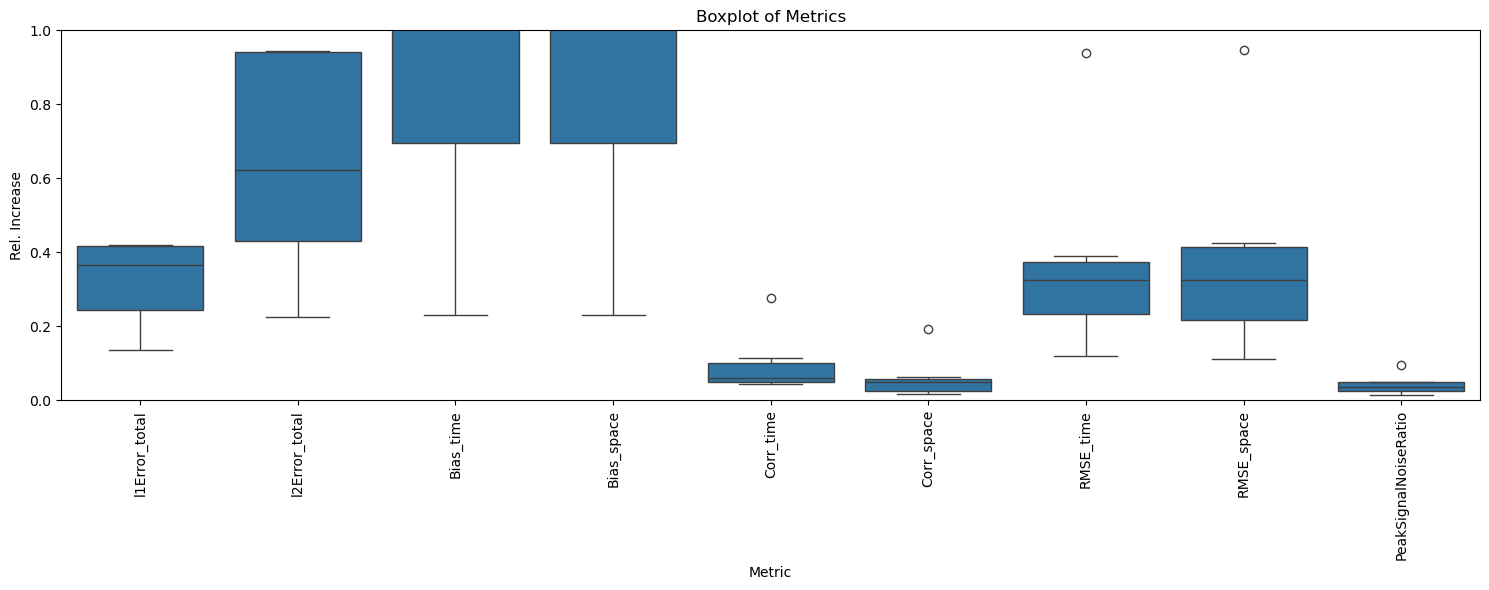

In [88]:
plt.figure(figsize=(15, 6))
sns.boxplot(x="Metric", y="Value", data=metrics_df_filtered)
plt.xticks(rotation=90)
plt.title('Boxplot of Metrics')
plt.xlabel('Metric')
plt.ylabel('Rel. Increase')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

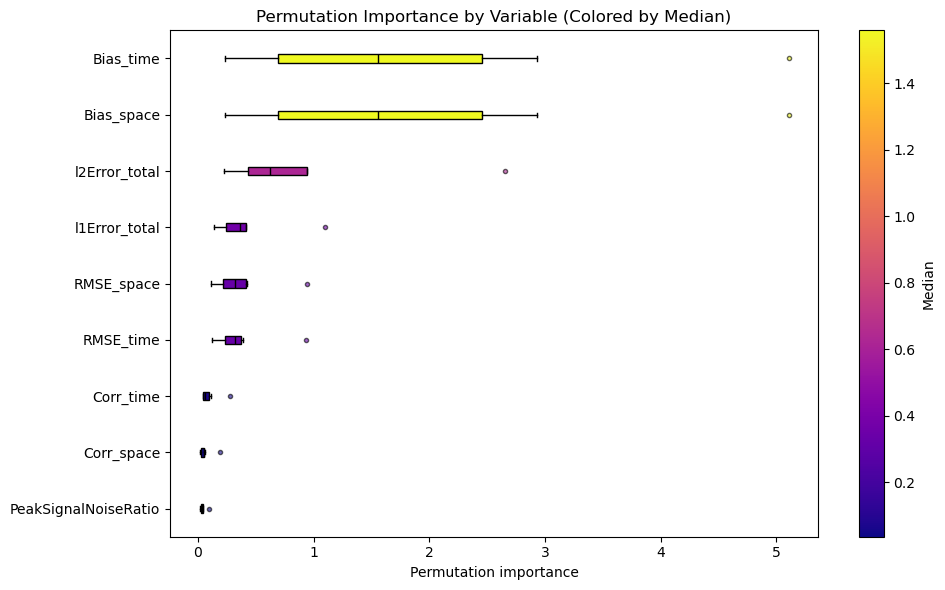

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Calcular la mediana de cada grupo
medians = metrics_df_filtered.groupby('Metric')['Value'].median()

# Ordenar de mayor a menor importancia
ordered_metrics = medians.sort_values(ascending=True).index

# Crear un mapa de colores basado en la mediana
norm = Normalize(vmin=medians.min(), vmax=medians.max())
cmap = plt.get_cmap("plasma")
colors = [cmap(norm(medians[feat])) for feat in ordered_metrics]

# Crear figura y ejes explícitamente
fig, ax = plt.subplots(figsize=(10, 6))

for i, var in enumerate(ordered_metrics):
    vals = metrics_df_filtered[metrics_df_filtered['Metric'] == var]['Value']
    bplot = ax.boxplot(vals, vert=False, positions=[i], patch_artist=True,
                       boxprops=dict(facecolor=colors[i], color='black'),
                       medianprops=dict(color='black'),
                       whiskerprops=dict(color='black'),
                       capprops=dict(color='black'),
                       flierprops=dict(markerfacecolor=colors[i], marker='o', color='black', markersize=3, alpha=0.6))

# Ejes y etiquetas
ax.set_yticks(np.arange(len(ordered_metrics)))
ax.set_yticklabels(ordered_metrics)
ax.set_xlabel("Permutation importance")
ax.set_title("Permutation Importance by Variable (Colored by Median)")

# Crear el ScalarMappable para la barra de colores
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Pasar el eje para que plt.colorbar sepa dónde poner la barra
cbar = fig.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label("Median")

plt.tight_layout()
plt.show()


In [69]:
metrics_list = metrics_df_filtered['Metric'].unique()

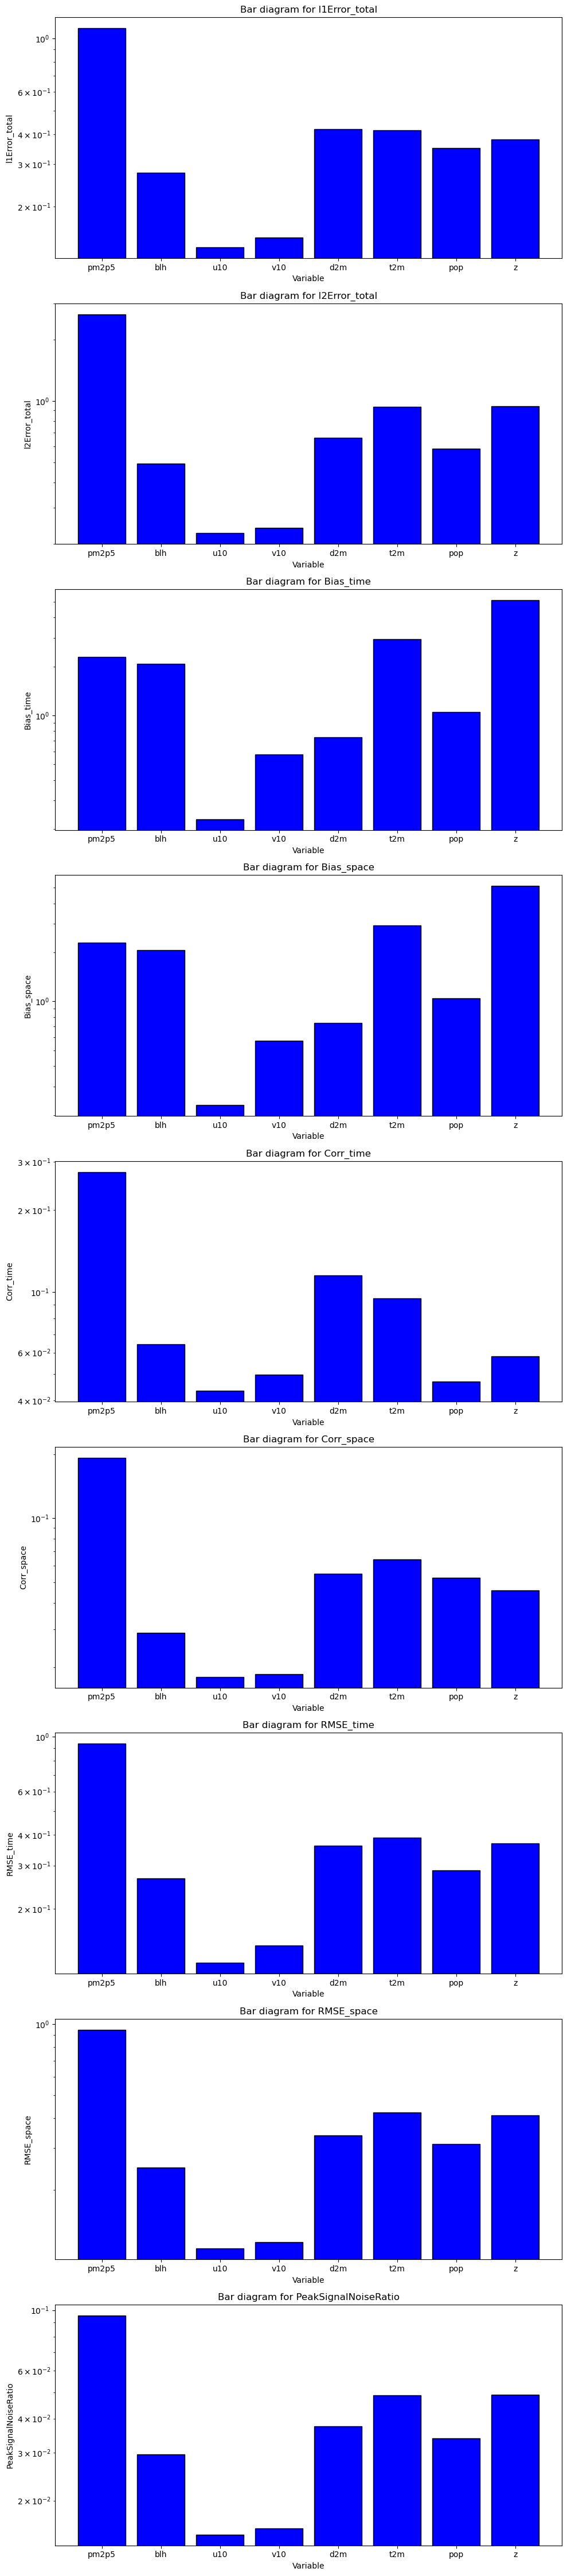

In [71]:
num_metrics = len(metrics_list)

fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(10, 5 * num_metrics))

# Si solo hay un gráfico, lo convertimos a una lista para iterar
if num_metrics == 1:
    axes = [axes]

# Dibujar un barplot para cada métrica
for i, metric in enumerate(metrics_list):
    ax = axes[i]
    metric_data = metrics_df_filtered[metrics_df_filtered['Metric'] == metric]
    
    # Usamos los valores directos (no promediamos)
    var_values = metric_data['Variable']
    metric_values = metric_data['Value']
        
    # Dibujar las barras
    ax.bar(var_values, metric_values, color='blue', edgecolor='black')
    
    #ax.set_ylim(bottom=0)
    
    ax.set_title(f'Bar diagram for {metric}')
    ax.set_xlabel('Variable')
    ax.set_ylabel(f'{metric}')
    ax.set_yscale('log')
    ax.set_xticks(var_values)  # Aseguramos que las var estén en el eje X
    
# Ajustar el diseño
plt.tight_layout()
plt.show()

#### Visualizing Map Metrics

#### Obtain the map values

In [72]:
# Paths to read coords, name vars and save data
cerra_data_dir = os.path.join(os.getcwd(), '../..' ,'data', 'CERRA', 'preprocessed_separate')
cerra_files = glob.glob(os.path.join(cerra_data_dir, 'test') + "/**/*.nc", recursive=True)
ds_cerra = xr.open_dataset(os.path.join(cerra_data_dir, cerra_files[0]))

In [73]:
# List of interesting metrics
time_metrics_of_interest = ["Bias_map_time", "Corr_map_time", "RMSE_map_time"]#, "Bias_map_time_sl", "Corr_map_time_sl", "RMSE_map_time_sl"]
space_metrics_of_interest = ["Bias_map_space", "Corr_map_space", "RMSE_map_space"]#, "Bias_map_space_sl", "Corr_map_space_sl", "RMSE_map_space_sl"]

# Create empty lists
time_results = np.zeros((len(time_metrics_of_interest), len(all_channel_names), ds_cerra.latitude.shape[0], ds_cerra.longitude.shape[0]))
space_results = np.zeros((len(space_metrics_of_interest), len(all_channel_names), ds_cerra.time.shape[0]))

# time
for i, metric in enumerate(time_metrics_of_interest):
    for j, var in enumerate(all_channel_names):
        key = f"{var}/{metric}"  
        if key in metrics_diff: #all_metrics:
            time_results[i, j] = metrics_diff[key].squeeze(0).numpy() #all_metrics[key]  

# space
for i, metric in enumerate(space_metrics_of_interest):
    for j, var in enumerate(all_channel_names):
        key = f"{var}/{metric}"  
        if key in metrics_diff: #all_metrics:
            space_results[i, j, :] = metrics_diff[key].squeeze(0).numpy() #all_metrics[key]  

In [74]:
coords = {dim: ds_cerra.coords[dim] for dim in ['time', 'latitude', 'longitude']}

# Convert to xarray 
time_ds = xr.Dataset({metric: (["variable", "latitude", "longitude"], time_results[i]) for i, metric in enumerate(time_metrics_of_interest)},
    coords={"variable": all_channel_names, "latitude": coords['latitude'], "longitude": coords['longitude']},
)

# Crear el dataset para 'space'
space_ds = xr.Dataset({metric: (["variable", "time"], space_results[i]) for i, metric in enumerate(space_metrics_of_interest)},
    coords={"variable": all_channel_names,"time": coords['time']})

In [75]:
def plot_time_metric(dataset, metric, vmin=None, vmax=None):
    """
    Plot of the 8 variables given a xarray.Dataset with dimensions (var, lat, lon).
    
    Parameters:
        dataset (xr.Dataset): Dataset with metrics.
        metric (str): name of the metric.
    """
    if metric not in dataset:
        raise ValueError(f"The metric '{metric}' is not in the dataset.")

    cmap = "viridis"
    extent = [dataset.longitude.min(), dataset.longitude.max(), dataset.latitude.min(), dataset.latitude.max()]
    
    vars = dataset["variable"].values  

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    #vmin, vmax = dataset[metric].min().item(), dataset[metric].max().item()  

    for i, var in enumerate(vars):            
        ax = axes[i]
        ax.set_extent(extent)
        gls = ax.gridlines(alpha=0.5, draw_labels=True, dms=True)
        gls.right_labels = False
        gls.top_labels = False
        ax.coastlines(resolution='10m')
        
        data = dataset[metric].sel(variable=var)

        if vmin == None:
            vmin = data.min().item()
        if vmax == None:
            vmax = data.max().item()  

        im = ax.pcolormesh(dataset["longitude"], dataset["latitude"], data.values, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
        cbar.set_label(label=f'{metric}',size=14, labelpad=10)
        ax.set_title(f'{var}')

    # Ajustar diseño
    fig.suptitle(f"Métrica: {metric}", fontsize=16)
    plt.subplots_adjust(right=0.9, top=0.95)
    
    plt.show()

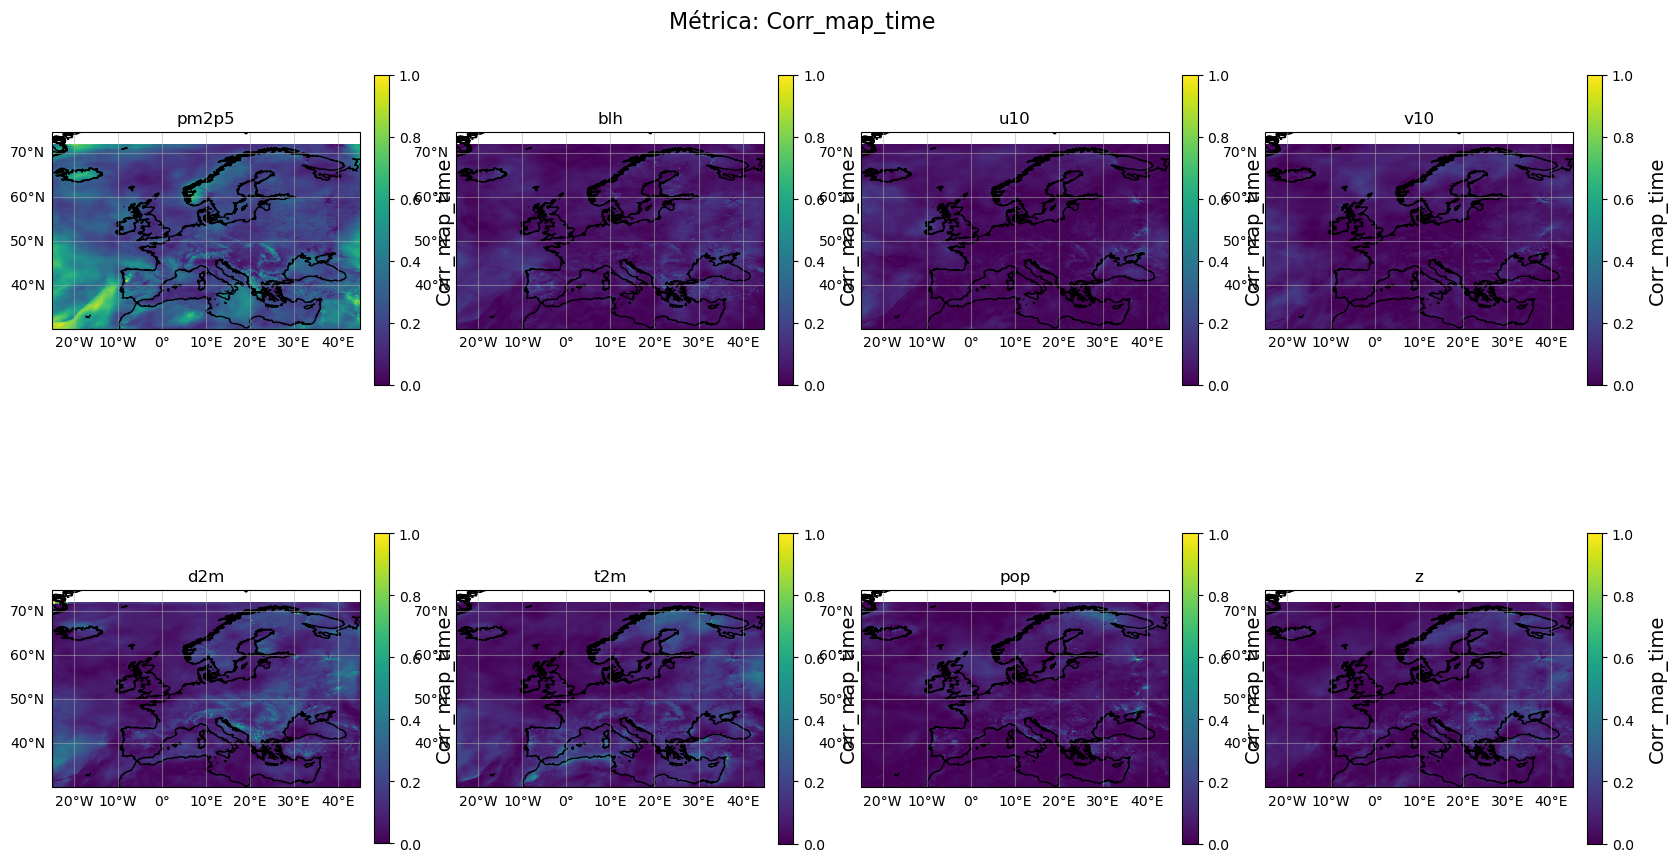

In [76]:
plot_time_metric(time_ds, "Corr_map_time", vmin=0, vmax=1)

In [77]:
import matplotlib.dates as mdates

def plot_space_metric(dataset, metric):
    """
    Plot the different variables for a given metric from a spatial xarray.Dataset in 8 subplots.
    
    Parameters:
        dataset (xr.Dataset): Dataset with metrics (dimensions: frame, time).
        metric (str): Name of the metric to plot.
    """
    if metric not in dataset:
        raise ValueError(f"The metric '{metric}' is not in the dataset.")

    dataset = dataset.sortby("time")  # Asegura orden temporal
    vars = dataset["variable"].values  
    time_values = dataset["time"].values  

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, var in enumerate(vars):
        ax = axes[i]
        data = dataset[metric].sel(variable=var)
        
        ax.plot(time_values, data)
        ax.set_title(f'{var}')
        ax.grid(True)
        ax.set_ylabel(metric)
        ax.set_xlabel("Time")
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # muestra mes y año

        for label in ax.get_xticklabels():
            label.set_rotation(45)

    fig.suptitle(f"Metric vs time: {metric}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  
    plt.show()


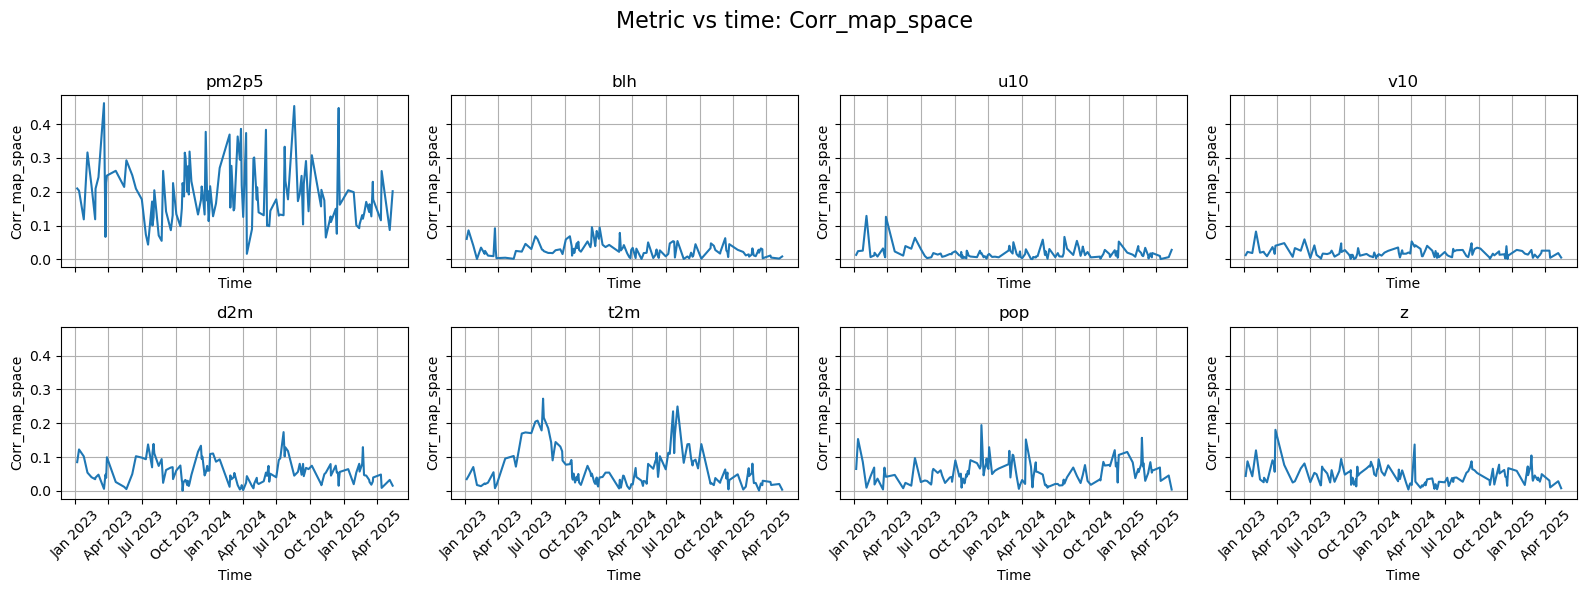

In [78]:
plot_space_metric(space_ds, "Corr_map_space")

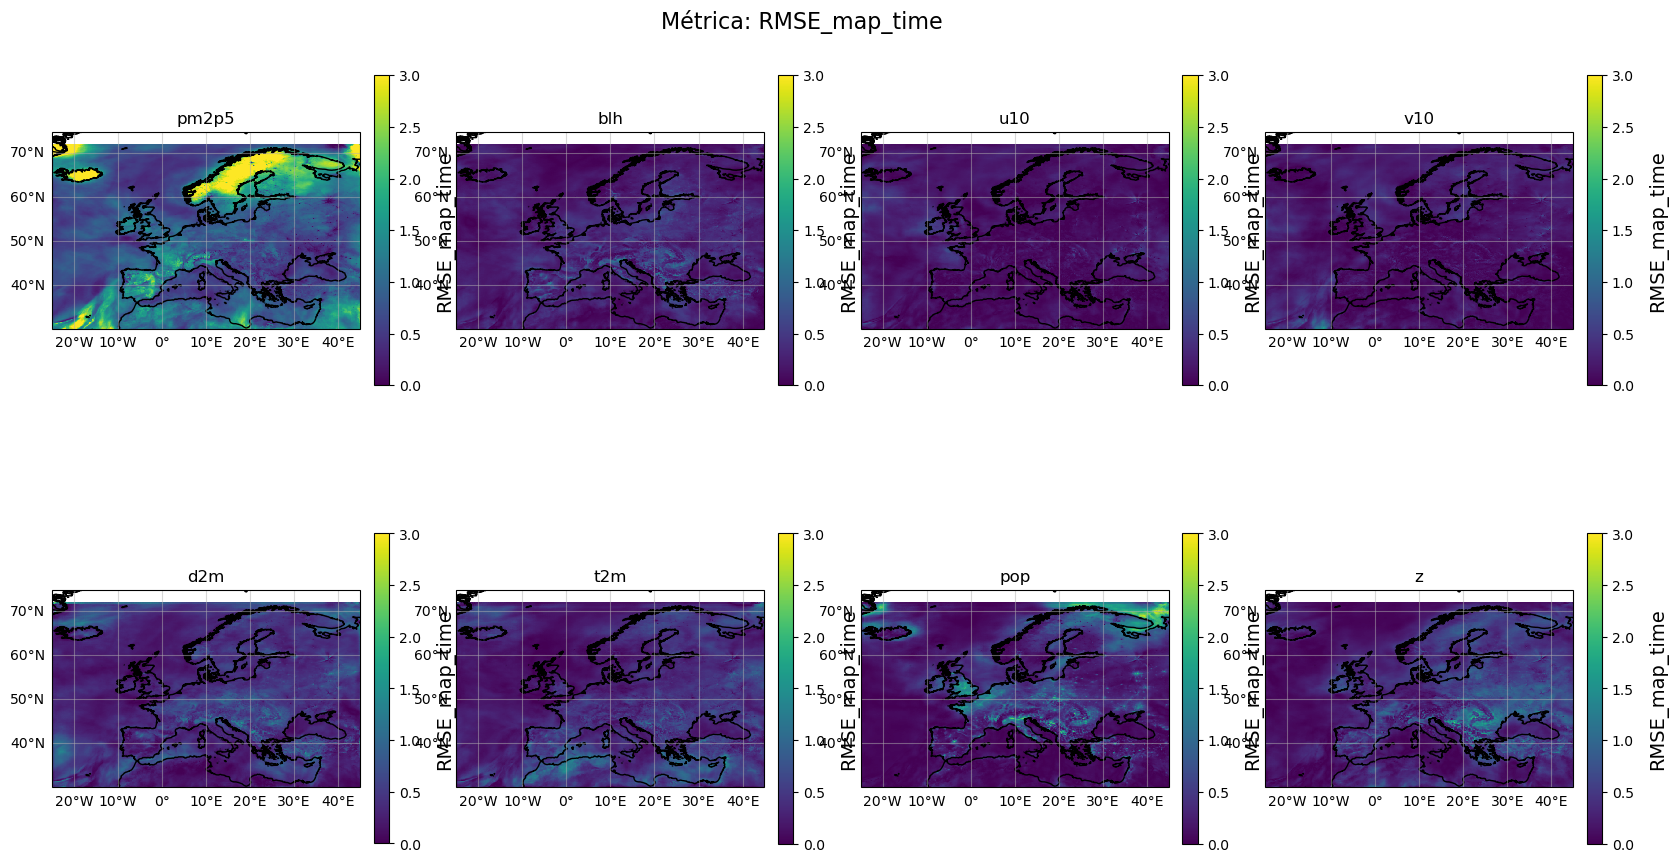

In [84]:
plot_time_metric(time_ds, "RMSE_map_time", vmin=0, vmax=3)

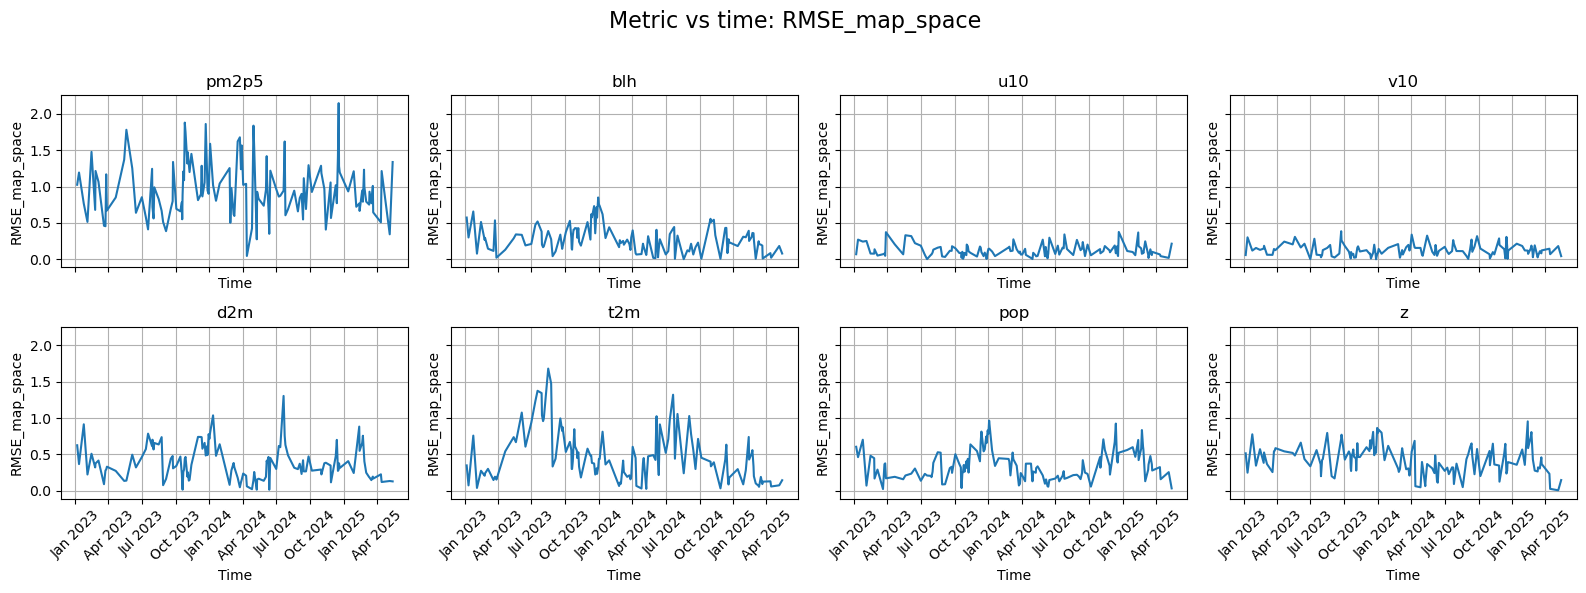

In [80]:
plot_space_metric(space_ds, "RMSE_map_space")

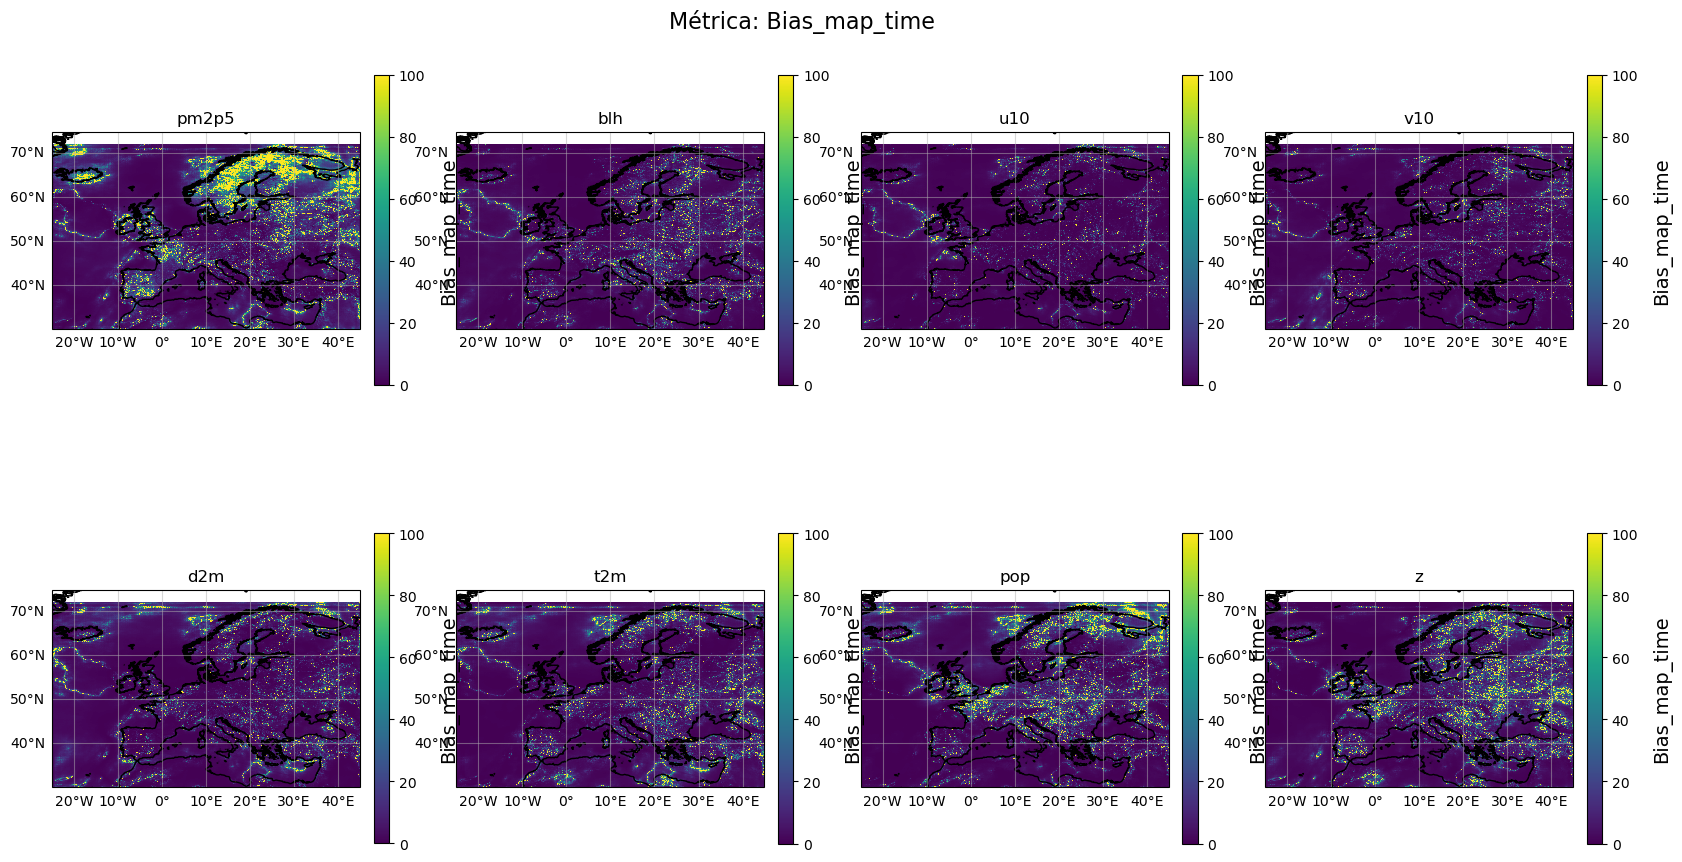

In [86]:
plot_time_metric(time_ds, "Bias_map_time", vmin=0, vmax=100)

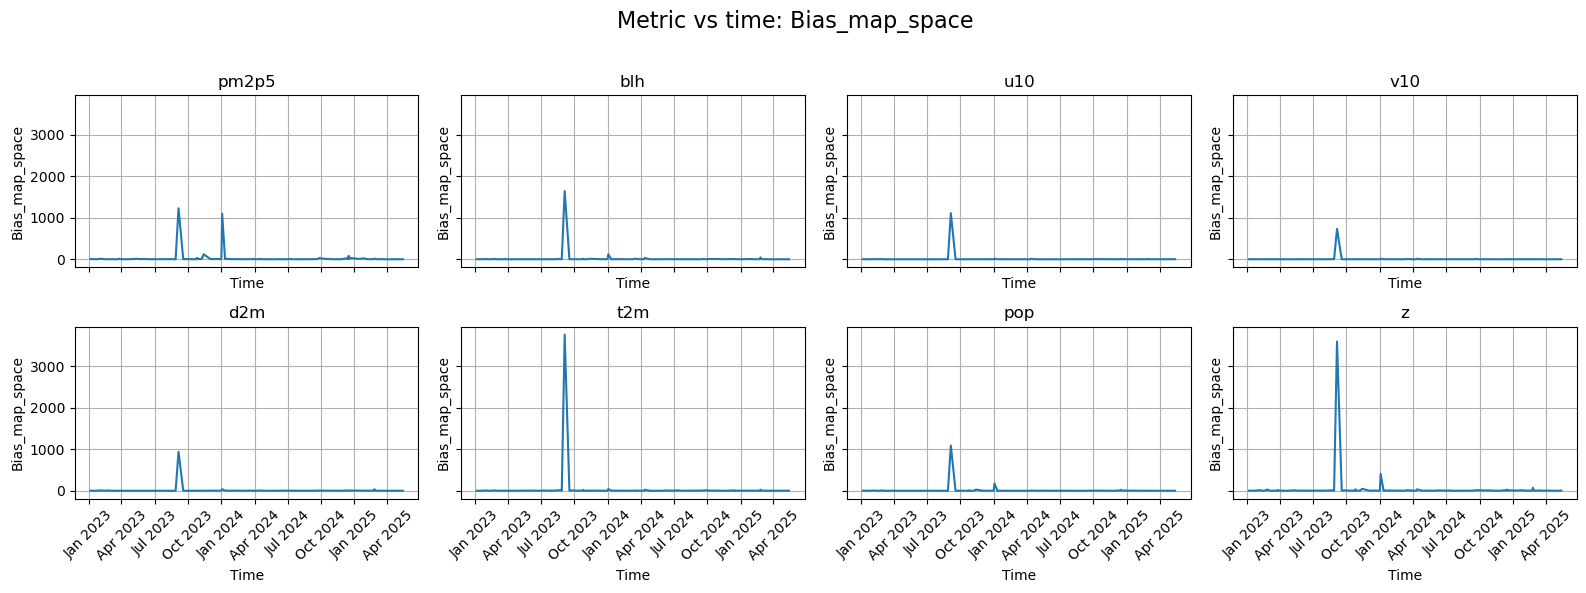

In [87]:
plot_space_metric(space_ds, "Bias_map_space")